# Jitter Fisher Analysis

Telescope jitter will negatively effect an inference algorithm's ability to constrain all its other parameters. In the case of the TOLIMAN telescope, we are primarily concerned with the ability to constrain the binary separation. In this notebook we will perform a Fisher analysis to determine the effect of jitter on the ability to constrain these parameters.

First let's configure the notebook.

In [1]:
import os
os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')
# os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

import dLux as dl
import matplotlib.pyplot as plt
import dLuxToliman as dlT
import zodiax as zdx
from jax import numpy as np
import jax
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
# plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# Enable 64bit precision (note this must be run in the first cell of the notebook)
jax.config.update("jax_enable_x64", True)

## Building Model
Here we build our dLux forwards model with parametric jitter. We will model the jitter as a simple harmonic oscillation

In [2]:
oversample = 4
det_pscale = 0.375
det_npixels = 128
kernel_size = 17

jitter_params = {"A": 0.1, "phi": 0}  # these will vary
radial_orders = [2, 3]

In [3]:
src = dlT.AlphaCen()
det = dl.LayeredDetector([
    ('Jitter', dlT.SHMJitter(**jitter_params, kernel_size=kernel_size)),
    ('Downsample', dl.Downsample(oversample)),
])

osys = dlT.TolimanOpticalSystem(
    oversample=oversample,
    psf_pixel_scale=det_pscale,
    psf_npixels=det_npixels,
    radial_orders=radial_orders,
    )
osys = osys.divide('aperture.basis', 1e9) # Set basis units to nanometers

telescope = dl.Telescope(source=src, optics=osys, detector=det)


## Visualising the Jitter Parameters
Our jitter parameters are $r$, shear and $\phi$. $r$ is the magnitude of the jitter in pixels, $\phi$ is the angle of the jitter in degrees and shear is a measure of how linear the jitter is.

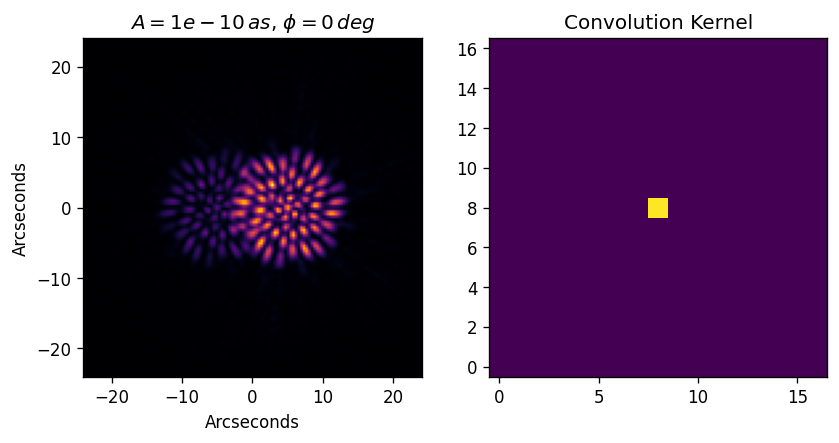

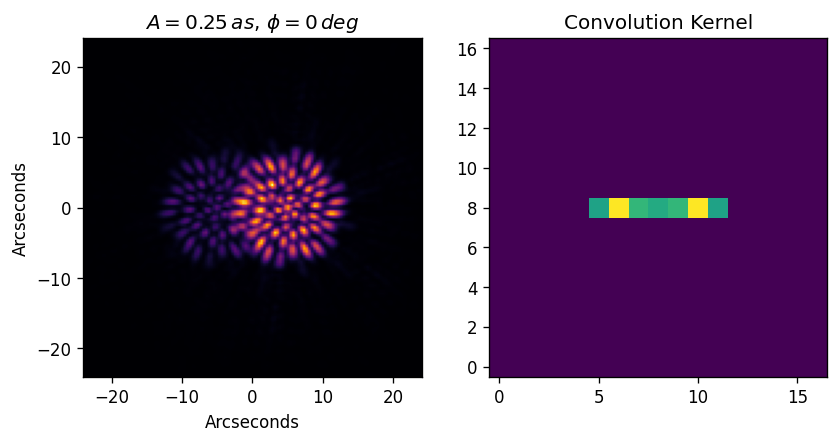

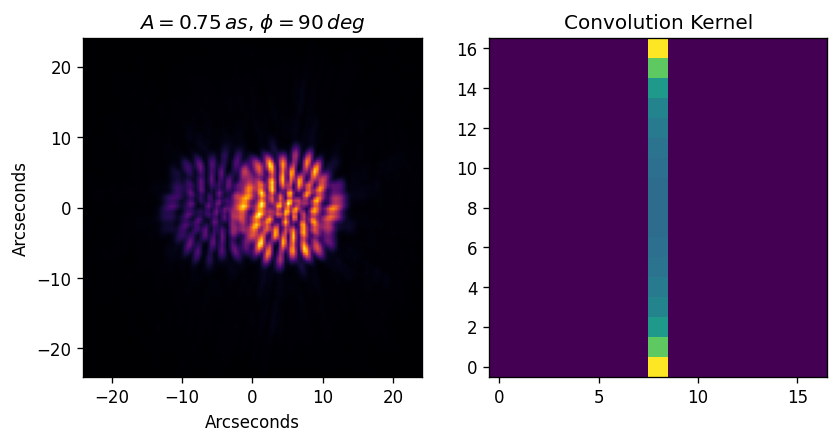

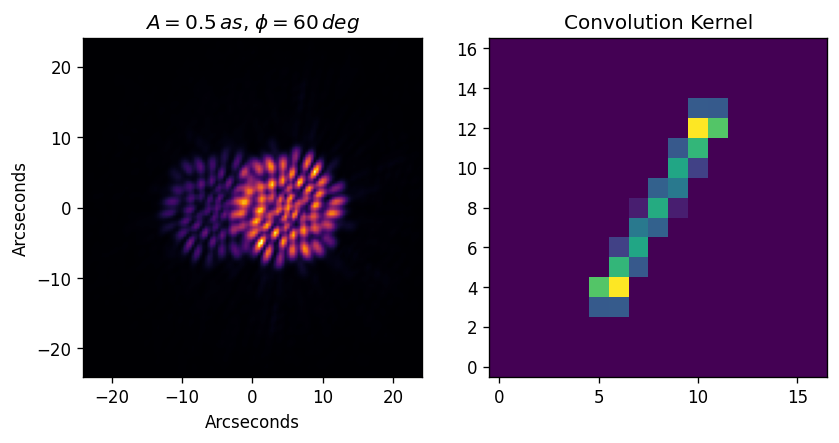

In [4]:
def show_jitter_example(telescope, A, phi):
    example_model = telescope.set(["detector.Jitter.A", "detector.Jitter.phi"], [A, phi])
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
    img = ax0.imshow(example_model.model(), extent=[-det_npixels/2*det_pscale, det_npixels/2*det_pscale, -det_npixels/2*det_pscale, det_npixels/2*det_pscale])
    ax0.set(title=f'$A={A}\,as$, $\phi={phi}\,deg$', xlabel='Arcseconds', ylabel='Arcseconds')
    c = ax1.imshow(example_model.detector.Jitter.generate_kernel(det_pscale/oversample), cmap='viridis')
    ax1.set(title='Convolution Kernel')
    plt.show()

show_jitter_example(telescope, 1e-10, 0)
show_jitter_example(telescope, 0.25, 0)
show_jitter_example(telescope, 2*det_pscale, 90)
show_jitter_example(telescope, 0.5, 60)

## Fisher Analysis
Now we will perform a Fisher analysis to determine the effect of jitter on the ability to constrain these parameters. We will do this by calculating the covariance matrix of the parameters of interest. We will then plot the standard deviation of each parameter as a function of the jitter magnitude.

Specifically we are interested in the `separation` as that is the science signal we aim to extract with TOLIMAN.

In [5]:
from jax import jit, grad, jvp, linearize, lax
import zodiax as zdx


def hvp(f, primals, tangents):
    return jvp(grad(f), primals, tangents)[1]


def hessian(f, x):
    _, hvp = linearize(grad(f), x)
    # Jit the sub-function here since it is called many timesc
    # TODO: Test effect on speed
    hvp = jit(hvp)
    basis = np.eye(np.prod(np.array(x.shape))).reshape(-1, *x.shape)
    return np.stack([hvp(e) for e in basis]).reshape(x.shape + x.shape)

def _perturb(X, pytree, parameters, shapes, lengths):
    n, xs = 0, []
    if isinstance(parameters, str):
        parameters = [parameters]
    indexes = range(len(parameters))

    for i, param, shape, length in zip(indexes, parameters, shapes, lengths):
        if length == 1:
            xs.append(X[i + n])
        else:
            xs.append(lax.dynamic_slice(X, (i + n,), (length,)).reshape(shape))
            n += length - 1

    return pytree.add(parameters, xs)

def FIM(
    pytree,
    parameters,
    loglike_fn,
    *loglike_args,
    shape_dict={},
    save_ram=True,
    **loglike_kwargs,
):
    # Build X vec
    pytree = zdx.tree.set_array(pytree, parameters)
    shapes, lengths = zdx.bayes._shapes_and_lengths(pytree, parameters, shape_dict)
    X = np.zeros(zdx.bayes._lengths_to_N(lengths))

    # Build function to calculate FIM and calculate
    # @jax.hessian
    def calc_fim(X):
        parametric_pytree =_perturb(X, pytree, parameters, shapes, lengths)
        return loglike_fn(parametric_pytree, *loglike_args, **loglike_kwargs)

    if save_ram:
        return hessian(calc_fim, X)
    return jax.hessian(calc_fim)(X)

Max recommended kernel_size: 17


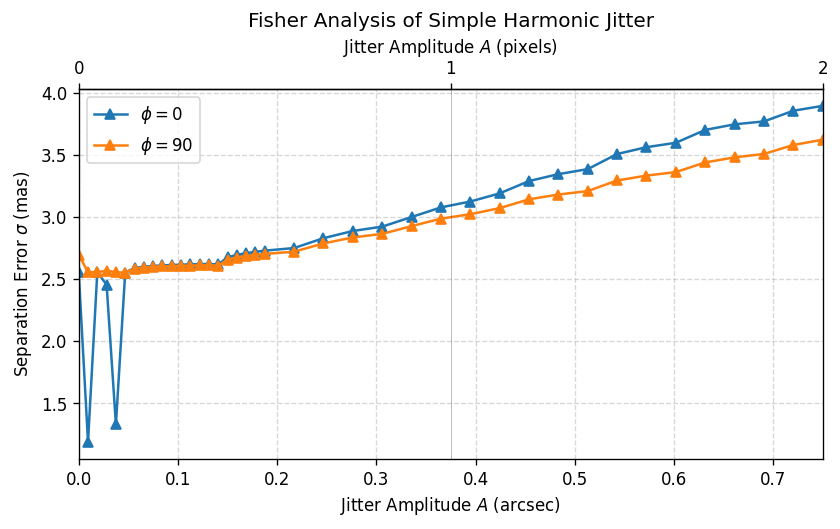

In [7]:
print("Max recommended kernel_size:", 
    telescope.set("detector.Jitter.A", As.max()).detector.Jitter.optimal_kernel_size(det_pscale/oversample),
)

fig, ax = plt.subplots(figsize=(8, 4))
for sep, phi in zip(seps.T, phis):
    ax.plot(As, 1000 * sep, label=f"$\phi={phi:.0f}$", marker='^')
# ax.axhline(2.6337281, linestyle='-.', c='k', label='LD Est.')

ax.set(
    xlabel='Jitter Amplitude $A$ (arcsec)',
    ylabel='Separation Error $\sigma$ (mas)',
    xlim=(0, As.max()),
    title="Fisher Analysis of Simple Harmonic Jitter"
)
ax.legend()
ax.grid(True, alpha=0.5, linestyle='--')

# Add secondary x-axis scale showing units of pixels
ax2 = ax.secondary_xaxis('top', functions=(lambda x: x/det_pscale, lambda x: x*det_pscale))
ax2.set(
    xlabel='Jitter Amplitude $A$ (pixels)',
    xticks=[0, 1, 2]
    )
ax.axvline(x=det_pscale, linestyle='-', color='k', alpha=0.3, linewidth=0.5)
plt.show()